In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('seaborn-darkgrid')

import seaborn as sns
import re

import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter



# II. Exploratory Data Analysis

### Project Contents

1. [Data Cleaning](../code/1_data_cleaning.ipynb)
2. [Data Visualization](../code/2_eda.ipynb) [This Notebook]
3. [Classifcation Model Comparison](../code/3_modeling.ipynb)

---

### Notebook Purpose

This notebook uses the cleaned data from notebook 1 and focuses on visualyzing linguistic and idiomatic differences between r/WallStreetBets and r/Investing post titles and post bodies (self text). 

---

Read in cleaned .CSV data

In [25]:
wsb_df = pd.read_csv('../data/wsb_df_clean.csv')

inv_df = pd.read_csv('../data/inv_df_clean.csv')

# nltk.download('punkt')
# combine both dataframes
df = pd.concat([wsb_df, inv_df], axis=0)

Load SpaCy NLP model

In [4]:
nlp = spacy.load('en_core_web_md')

### Distribution of Post Length

WSB Post Length Stats: 


count    9859.000000
mean      121.329952
std       224.073690
min         1.000000
25%        44.000000
50%        68.000000
75%       122.000000
max      6204.000000
Name: post_length, dtype: float64

Investing Post Length Stats: 


count    9560.000000
mean      146.528661
std       204.894157
min         1.000000
25%        63.000000
50%        91.000000
75%       149.000000
max      3836.000000
Name: post_length, dtype: float64

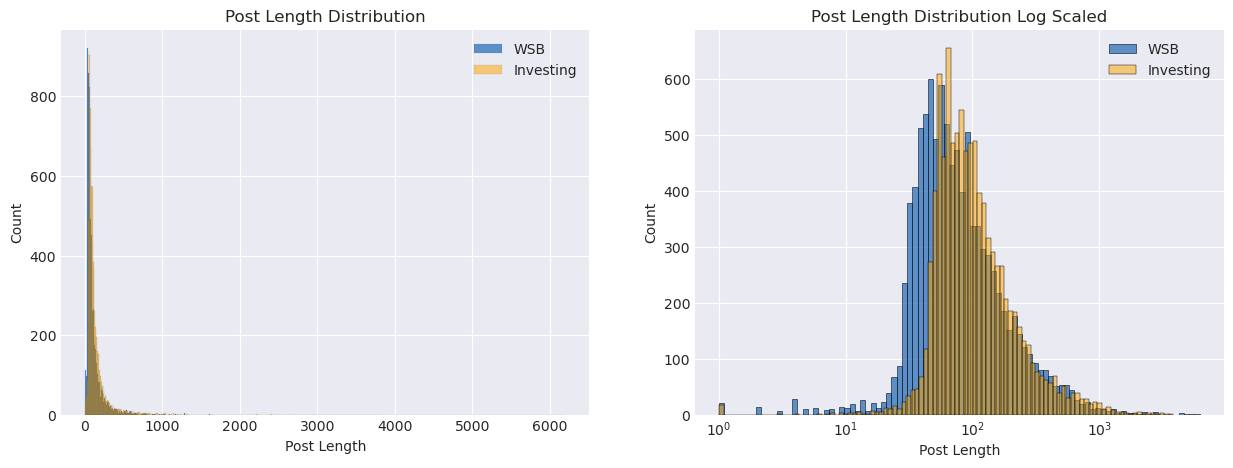

In [87]:
wsb_df['post_length'] = wsb_df['selftext'].str.split().str.len()
inv_df['post_length'] = inv_df['selftext'].str.split().str.len()

fig, ax = plt.subplots(1, 2, figsize=(15,5))

sns.histplot(wsb_df['post_length'], ax = ax[0], color = '#2c6fbb', label='WSB')
sns.histplot(inv_df['post_length'],  alpha = .50,ax = ax[0], color='orange')
ax[0].set_title('Post Length Distribution')
ax[0].set_xlabel('Post Length')
ax[0].set_ylabel('Count')
ax[0].legend()


sns.histplot(wsb_df['post_length'],  log_scale=True, ax=ax[1], color = '#2c6fbb')
sns.histplot(inv_df['post_length'],   alpha = .50, log_scale=True, ax=ax[1], color='orange')
ax[1].set_title('Post Length Distribution Log Scaled')
ax[1].set_xlabel('Post Length')
ax[1].set_ylabel('Count')

# add labels to legend with orange and blue color
ax[0].legend(['WSB', 'Investing'])
ax[1].legend(['WSB', 'Investing'])


print('WSB Post Length Stats: ')
display(wsb_df['post_length'].describe())
print('Investing Post Length Stats: ')
display(inv_df['post_length'].describe())

We begin our EDA by examining the distribution of word length in r/WallStreetBets and r/Investing posts. 

By examining the summary statistics tables as well as the histograms above, we see that both subreddits exhibit a similar word length distribution, with a mean post length of 121 and 146 words respectively. The variance in post length is similar as well, as exhibited by the plot of the two histograms overlayed over each other seen above. 

Additionally, both subreddits have post length outlier values well over 2000 words, with the longest r/WallStreetBets post containing over 6000 words. The very long posts make the histogram visualization difficult, so in the second visualization, the post length has been log transformed for greater visibility. We see that once log-transformed, both subreddits' post length follow a mostly-normal distribution and that r/investing's post length mean is slightly to the right of r/WallStreetBets.

### Number of Unique Users in each subreddit

Text(0, 0.5, 'Number of Unique Authors')

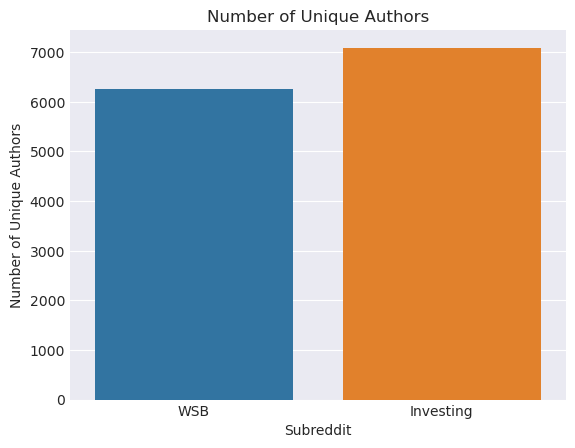

In [90]:
wsb_df['author'].nunique()

inv_df['author'].nunique()

sns.barplot(x=['WSB', 'Investing'], y=[wsb_df['author'].nunique(), inv_df['author'].nunique()])
plt.title('Number of Unique Authors')
plt.xlabel('Subreddit')
plt.ylabel('Number of Unique Authors')



In the above visualization, we compare the number of unique authors in r/WSB and r/investing. We see that while r/WSB is the more popular subreddit, with 13.3 million members, r/investing has more unique authors, having roughly 1,000 more unique authors than r/WSB. 

### Most Common Titular words 

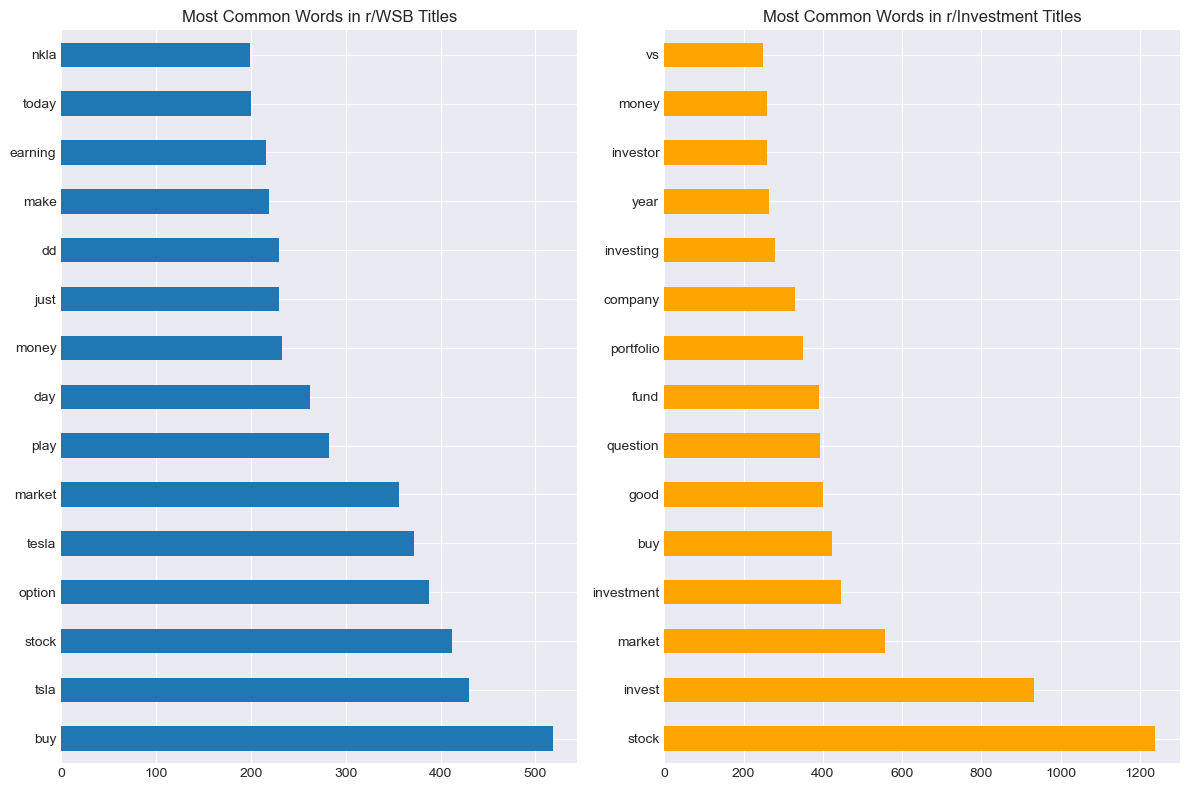

In [8]:
cvec = CountVectorizer(stop_words='english', max_features=10_000)

# fit
cvec.fit(wsb_df['title_lemmatized'])

# wsb fit dataframe
cvec_df = pd.DataFrame(cvec.transform(wsb_df['title_lemmatized']).todense(), columns=cvec.get_feature_names_out())

# plot
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
cvec_df.sum().sort_values(ascending=False).head(15).plot(kind='barh', ax=ax[0], 
                                                        title='Most Common Words in r/WSB Titles')

# invest fit
cvec.fit(inv_df['title_lemmatized'])

# invest fit dataframe
cvec_df = pd.DataFrame(cvec.transform(inv_df['title_lemmatized']).todense(), columns=cvec.get_feature_names_out())
cvec_df.sum().sort_values(ascending=False).head(15).plot(kind='barh', ax = ax[1], 
                                                        color = 'orange', 
                                                        title='Most Common Words in r/Investment Titles')

plt.tight_layout()

It is well documented that there is a clear difference in philosophy and approach between r/WallStreetBets and essentially any other financial forum. The barplot above of the most common words used in the titles of the two financial subreddits makes this abundantly clear. Many of the r/WallStreetBets top title words are terms associated with short-term trading strategies as well as well as high-risk, high reward leveraged trading strategies, some of these terms include:

- earning
- day
- today
- option

A favored (but unsophisticated) trading strategy amongst r/WallStreetBets posters is to make highly leveraged trades (using options) shortly before a company's quarterly earnings reports. Thus it is unsurprising we see a high frequency of words and terms that might relate strongly to this strategy. 

Unlike r/WallStreetBeys, many of the top terms associated with r/Investment titles relate to longer-term strategies. Some of these terms (which are noticeably absent in the r/WallStreetBets titles) include:

- stock
- investment
- market
- portfolio
- fund

**The Elon Effect and Fast Cash**

We will see many references to Tesla, the electric vehicle company, as well as other events or holdings related to Elon Musk's business empire across both subreddits, but WallStreetBettors are particularly interested in Tesla or companies of a similar ilk. We see that amongst the top-five r/WallStreetBets title words, Tesla as well as it's stock ticker symbol TSLA are mentioned, as well as NKLA the stock ticker symbol for a penny-stock electric-vehicle start up.

**Idiomatic Axioms**

The presence of "dd" in the most frequent words amongst r/WallStreetBets titles might seem like a typo at first glance, however "dd" is actually r/WallStreetBets speak for "due diligence" or the idea that a poster has done their "homework" on some security before posting to the larger community. We also observe the use of the word "play" which is often used in conjunction with the word option. An "option play" might mean that a poster is proposing a high-leverage trade on some security that they have done their "dd" on. 

### Most Common Selftext words

<AxesSubplot:title={'center':'Top 20 Words in r/Investment Selftext'}>

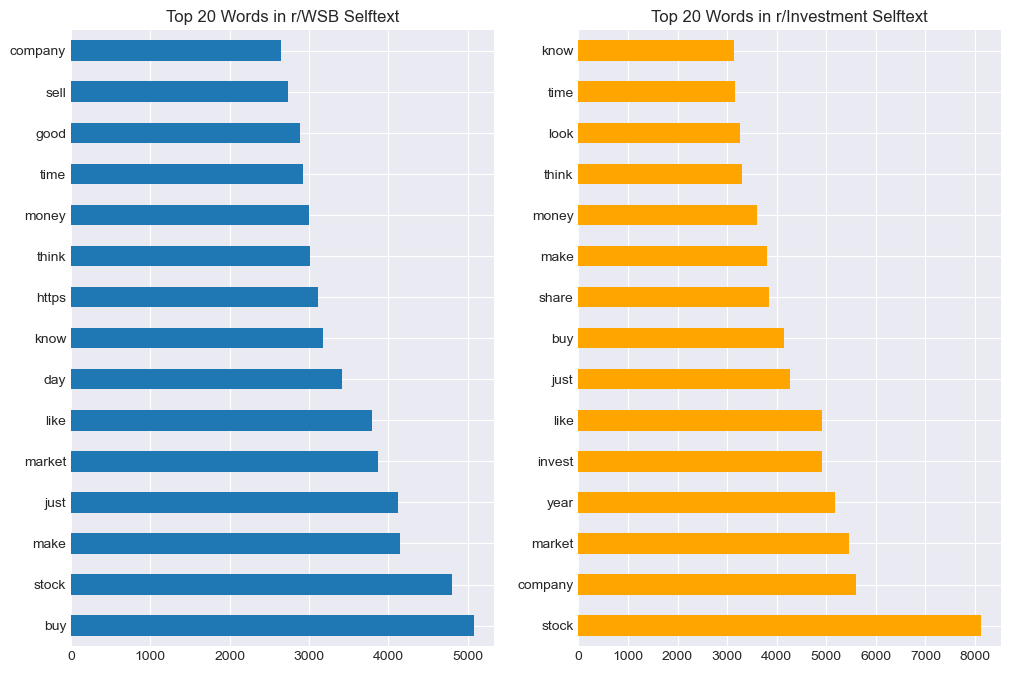

In [9]:
# top 20 words in wsb titles
cvec.fit(wsb_df['selftext_lemmatized'])
cvec_df = pd.DataFrame(cvec.transform(wsb_df['selftext_lemmatized']).todense(), columns=cvec.get_feature_names_out())
fig, ax = plt.subplots(1, 2, figsize=(12,8))
cvec_df.sum().sort_values(ascending=False).head(15).plot(kind='barh', ax=ax[0], title='Top 20 Words in r/WSB Selftext')

cvec.fit(inv_df['selftext_lemmatized'])
cvec_df = pd.DataFrame(cvec.transform(inv_df['selftext_lemmatized']).todense(), columns=cvec.get_feature_names_out())
cvec_df.sum().sort_values(ascending=False).head(15).plot(kind='barh', color = 'orange', title='Top 20 Words in r/Investment Selftext')

The bar plots above show the most common words used in selftext across both subreddits. In comparison to titles, the two subreddits share a number of common words, such as:
- buy
- company
- market
- know
- money 
- time
- think
- like

The similarity is not shocking, as the two subreddits share the same subject matter albeit with different financial goals and philosophies. The stark difference in word usage between titles and more common word usage in self-text raises the question of whether titles will have more predictive power than selftext or titles and self text when we move the classification modeling. All of these options are explored in the [Modeling Notebook](../code/3_modeling.ipynb).

### Use of Emojis

In [69]:
# how much more likely is a wallstreet bets post to have '🚀', '🙌', '🐻', '🐂', '💵', '🍗','💎' than a investing post

wsb_emojis = ['🚀', '🙌', '🐻', '🐂', '💵', '🍗','💎']

def go_brr(df):
    emoji_dict = {}
    for emoji in wsb_emojis:
        emoji_dict[emoji] = len(df['title'].str.findall(emoji).sum()) + len(df['selftext'].str.findall(emoji).sum())
    return emoji_dict

# how much more likely is a wallstreet bets post to have '🚀', '🙌', '🐻', '🐂', '💵', '🍗','💎' than a investing post

wsb_emojis = ['🚀', '🙌', '🐻', '🐂', '💵', '🍗','💎']

def go_brr(df):
    emoji_dict = {}
    for emoji in wsb_emojis:
        emoji_dict[emoji] = len(df['title'].str.findall(emoji).sum()) + len(df['selftext'].str.findall(emoji).sum())
    return emoji_dict

wsb_emoji_dict = go_brr(wsb_df)
inv_emoji_dict = go_brr(inv_df)

wsb_emoji_df = pd.DataFrame(wsb_emoji_dict, index=['WSB']).T
inv_emoji_df = pd.DataFrame(inv_emoji_dict, index=['Investing']).T

# probability
wsb_emoji_df['probability'] = wsb_emoji_df['WSB'] / wsb_df.shape[0]

display(wsb_emoji_df)

inv_emoji_df['probability'] = inv_emoji_df['Investing'] / inv_df.shape[0]

display(inv_emoji_df)




,WSB,probability
🚀,649,0.065828
🙌,8,0.000811
🐻,385,0.039051
🐂,19,0.001927
💵,7,0.000710
🍗,9,0.000913
💎,24,0.002434


,Investing,probability
🚀,26,0.002720
🙌,0,0.000000
🐻,0,0.000000
🐂,0,0.000000
💵,6,0.000628
🍗,0,0.000000
💎,0,0.000000


Unfortunately Matplotlib cannot handle Emoji's properly at present, however the dataframes presented above suffice. 

**💎	Hands**

r/WallStreetBets is infamous for using a confusing syntax of emojis and slang to express investment sentiment ([SOURCE](https://www.stash.com/learn/stashs-guide-to-reddits-wallstreetbets-can-help-you-understand-the-lingo/)). 

A r/WSB poster that has done their "DD" (Due diligence) on a security will then hold it through whatever waves of volatility they might experience. While doing this, they are said to hold on with "diamond hands" expressed as 💎🙌. They do this so they might stack "tendies" or 🍗 (the etymology of this symbol is confusing, but roughly speaking: tendies is slang for legal tender, so tendies can also be a chicken wing as tender = chicken tender = chicken wing).

Without diving too deep into this confusing syntacical landscape, we can see that certain emojis are far more prevalent in r/WallStreetBets than r/Investing, for example the 🚀, emoji, symbolizing the sentiment that a security will "go to the moon", is 32 times more likely to be in a r/WallStreetBets post than a r/Investment post. The mere presence of these symbols will likely suffice for our classification purposes, and for the ultimate purpose of spam-bot construction, we'll just note that one subreddit is far more likely to have the emoticons than another. 

### Most Common Bigrams

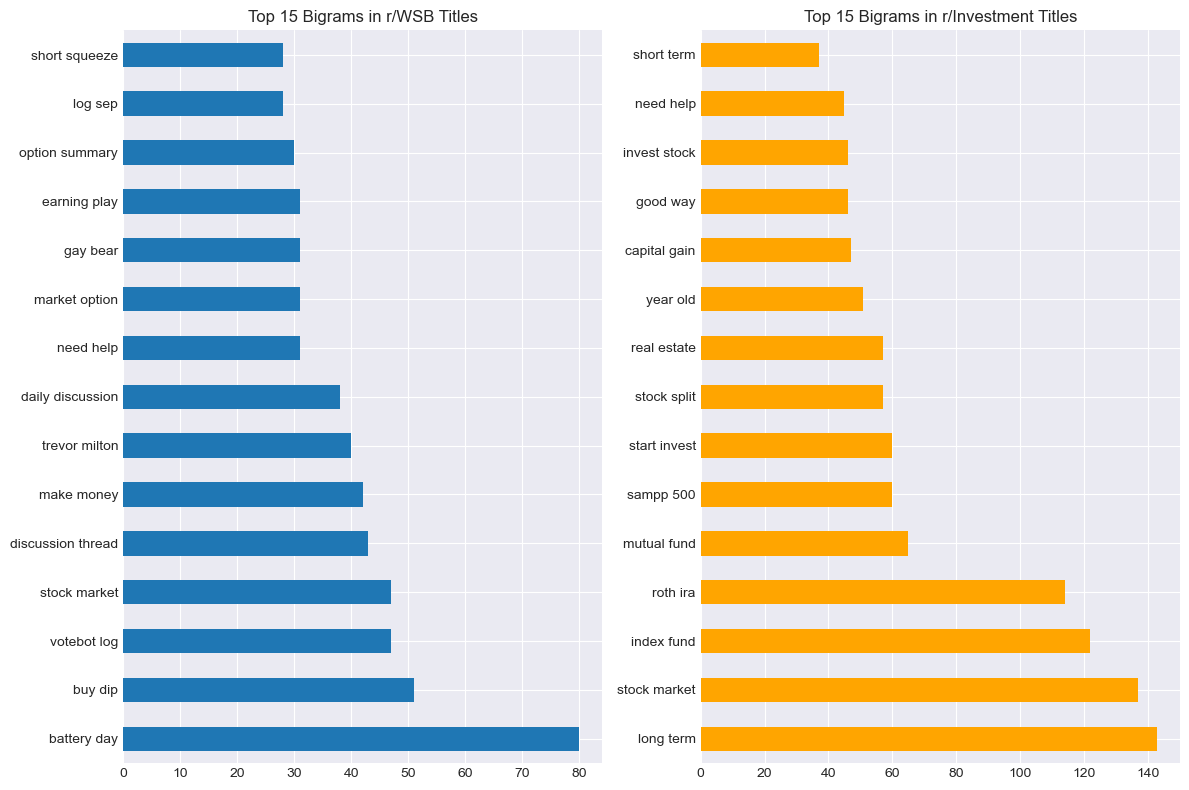

In [10]:
# top 20 trigrams in wsb titles
cvec = CountVectorizer(stop_words='english', ngram_range=(2,2), max_features=10_000)
cvec.fit(wsb_df['title_lemmatized'])
cvec_df = pd.DataFrame(cvec.transform(wsb_df['title_lemmatized']).todense(), columns=cvec.get_feature_names_out())
fig, ax = plt.subplots(1, 2, figsize=(12,8))
cvec_df.sum().sort_values(ascending=False).head(15).plot(kind='barh', ax=ax[0], title='Top 15 Bigrams in r/WSB Titles')

cvec.fit(inv_df['title_lemmatized'])
cvec_df = pd.DataFrame(cvec.transform(inv_df['title_lemmatized']).todense(), columns=cvec.get_feature_names_out())
cvec_df.sum().sort_values(ascending=False).head(15).plot(kind='barh', color = 'orange', title='Top 15 Bigrams in r/Investment Titles')
plt.tight_layout()


The plot above is an $n$-gram analysis of the most frequent two-word combinations used in the two subreddits. The formal definition of an $n$-gram is: *a contiguous sequence of $n$ items from a given sample of text or speech* ([SOURCE](https://towardsdatascience.com/text-analysis-basics-in-python-443282942ec5)).

Much like with common words in titles, we see a stark contrast in bigrams used in the two subreddits.

Whereas in r/Investing the three most common bigrams are "long term", "stock market", and "index fund" in r/WallStreetBets we see "battery day", "buy dip" and "votebot log".

While "long term", "stock market" and "index fund" are relatively self-explanatory, the two of the most frequent bigrams in r/WallStreetBets require further elucidation.

**Battery Day** - Is an annual Tesla PR event where the company announces new projects or major changes to its product line. WallStreetBettors view this as an opportunity to make high-risk/high-reward short term investment plays.

**Votebot Log** - Votebot is software intended to fradulenty participate in online social-media activities such as polls or forums. Fraudsters have recently found r/WallStreetBets to be furtile ground for bot-driven pump-and-dump investment activity, with one WallStreet research firm, Epsilon Theory, stating that in an analysis of 30,000 posts over 24 hours, 97% appeared to be created fraudulently by bots. ([SOURCE](https://www.cbsnews.com/news/wallstreetbets-reddit-bot-activity/)). 

Thus the frequent occurence of Votebot Logs is likely an attempt by WallStreetBettors to verify the veracity of market news. 

### Most Common Trigrams

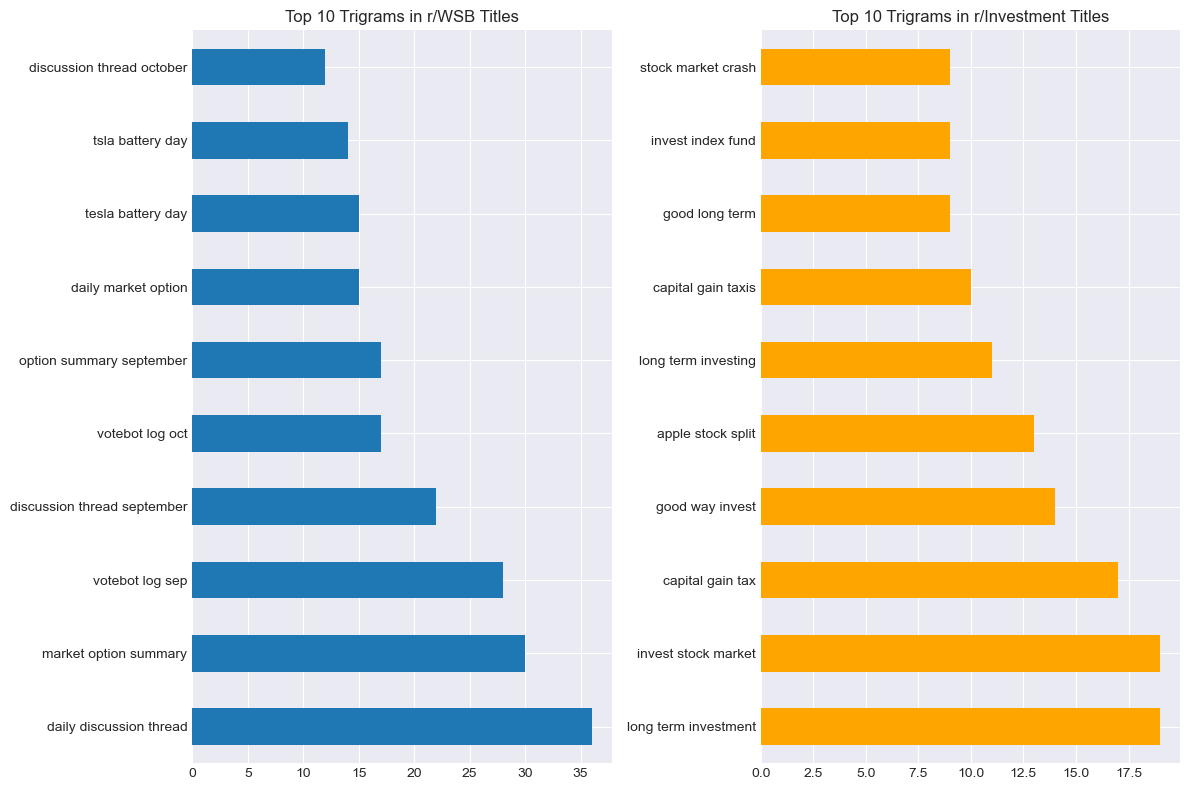

In [11]:
# top 20 trigrams in wsb titles
cvec = CountVectorizer(stop_words='english', ngram_range=(3,3), max_features=10_000)
cvec.fit(wsb_df['title_lemmatized'])
cvec_df = pd.DataFrame(cvec.transform(wsb_df['title_lemmatized']).todense(), columns=cvec.get_feature_names_out())
fig, ax = plt.subplots(1, 2, figsize=(12,8))
cvec_df.sum().sort_values(ascending=False).head(10).plot(kind='barh', ax=ax[0], title='Top 10 Trigrams in r/WSB Titles')

cvec.fit(inv_df['title_lemmatized'])
cvec_df = pd.DataFrame(cvec.transform(inv_df['title_lemmatized']).todense(), columns=cvec.get_feature_names_out())
cvec_df.sum().sort_values(ascending=False).head(10).plot(kind='barh', color = 'orange', title='Top 10 Trigrams in r/Investment Titles')
plt.tight_layout()


The plot above is a similar $n$-gram analysis to the previous barplot, however with *trigrams*, or 3 word contiguous phrases, rather than *bigrams*. We again see that the short vs. long-term distinction between the two subreddits, with trigrams such as "market option summary" and "tesla battery day" in r/WSB compared to "long term investment" and "capital gains tax" in r/Inv.

### Most Common Securities

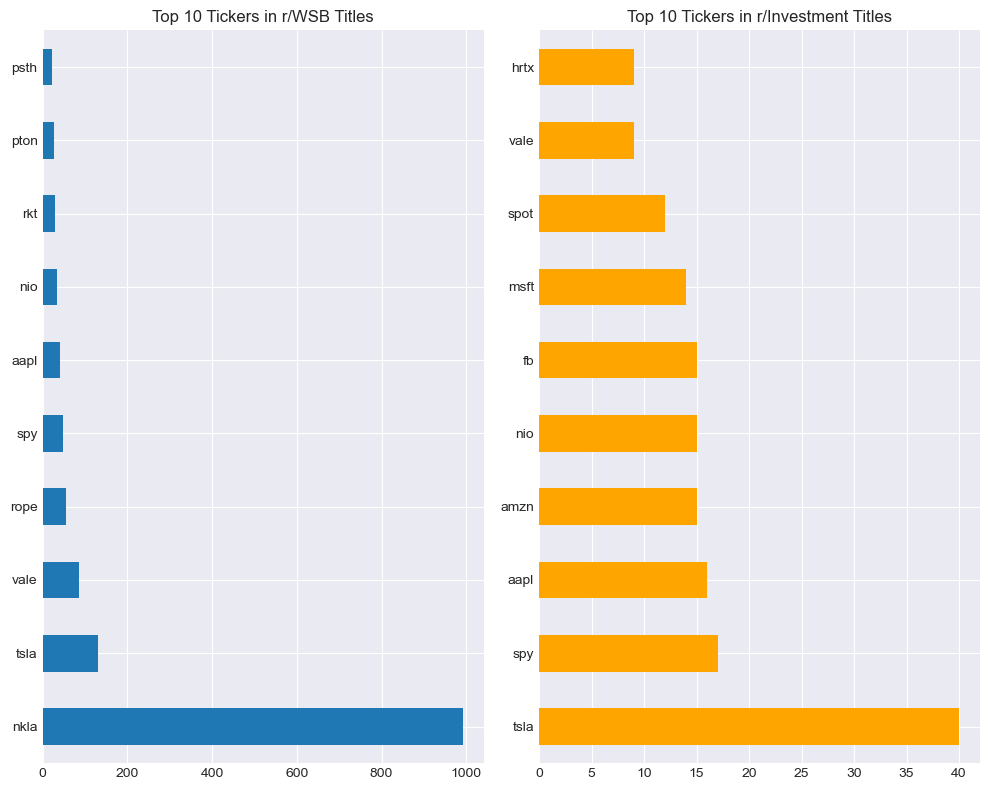

In [12]:
# get the stock tickers from the wsb titles
wsb_tickers = []
for title in wsb_df['title'] + wsb_df['selftext']:
    wsb_tickers.append(re.findall(r'[$][A-Za-z][\S]*', str(title)))

# get the stock tickers from the investing titles
inv_tickers = []
for title in inv_df['title'] + inv_df['selftext']:
    inv_tickers.append(re.findall(r'[$][A-Za-z][\S]*', str(title)))

# flatten the list of lists
wsb_tickers = [item.strip('$') for sublist in wsb_tickers for item in sublist]
inv_tickers = [item.strip('$') for sublist in inv_tickers for item in sublist]

# create a dataframe of the tickers
wsb_tickers_df = pd.DataFrame(wsb_tickers, columns=['ticker'])
inv_tickers_df = pd.DataFrame(inv_tickers, columns=['ticker'])

# remove the tickers that are not stock tickers
wsb_tickers_df = wsb_tickers_df[~wsb_tickers_df['ticker'].str.contains('nklankla')]
inv_tickers_df = inv_tickers_df[~inv_tickers_df['ticker'].str.contains('eri')]
# plot the top 10 tickers in wsb titles

fig, ax = plt.subplots(1, 2, figsize=(10,8))
wsb_tickers_df['ticker'].value_counts().head(10).plot(kind='barh', ax=ax[0], title='Top 10 Tickers in r/WSB Titles')
inv_tickers_df['ticker'].value_counts().head(10).plot(kind='barh', color = 'orange', title='Top 10 Tickers in r/Investment Titles')
plt.tight_layout()


Since both subreddits focus on the purchase and sale of securities in the capital markets, I felt it would be interesting to compare the occurrence of stock ticker symbols between the two. The results are informative: 

1. Stock tickers occur far more frequently in r/WallStreetBets than in r/Investing. The most mentioned stock ticker in r/Investing is TSLA with roughly 40 selftext mentions, whereas in r/WallStreetBets we see NKLA, a penny stock representing a electric vehicle battery startup mentioned nearly 1000 times, with TSLA the second most frequently mentioned ticker at approximately 160 times or four times the rate of occurence in r/Investing.

2. The extremely high ticker mention rates in r/WallStreetBets is indicative of the standard *modus operandi* of r/WallStreetBets posters: find a penny stock, mention it a lot, try to get others to pile into the stock, and hope the price rises. Whereas in r/Investing, there are no penny stock tickers, and the tickers mentioned are largely blue-chip, stable companies or index funds, such as AAPL, AMZN and SPY (an index fund that tracks the S&P 500), again reinforcing the short vs. long term paradigm between the two subreddits. 

In [13]:
# new dataframe 

wsb_tickers_df['wsb_count'] = 1
wsb_tickers_df['subbreddit'] = 'wsb'
wsb_tickers_df = wsb_tickers_df.groupby('ticker').aggregate({'wsb_count': 'sum'}).sort_values('wsb_count', ascending=False).head(15)

inv_tickers_df['inv_count'] = 1
inv_tickers_df['subbreddit'] = 'inv'
inv_tickers_df = inv_tickers_df.groupby('ticker').aggregate({'inv_count': 'sum'}).sort_values('inv_count', ascending=False).head(15)


# merge the two dataframes
tickers_df = pd.merge(wsb_tickers_df, inv_tickers_df, how='outer', on='ticker')
tickers_df = tickers_df.fillna(0)


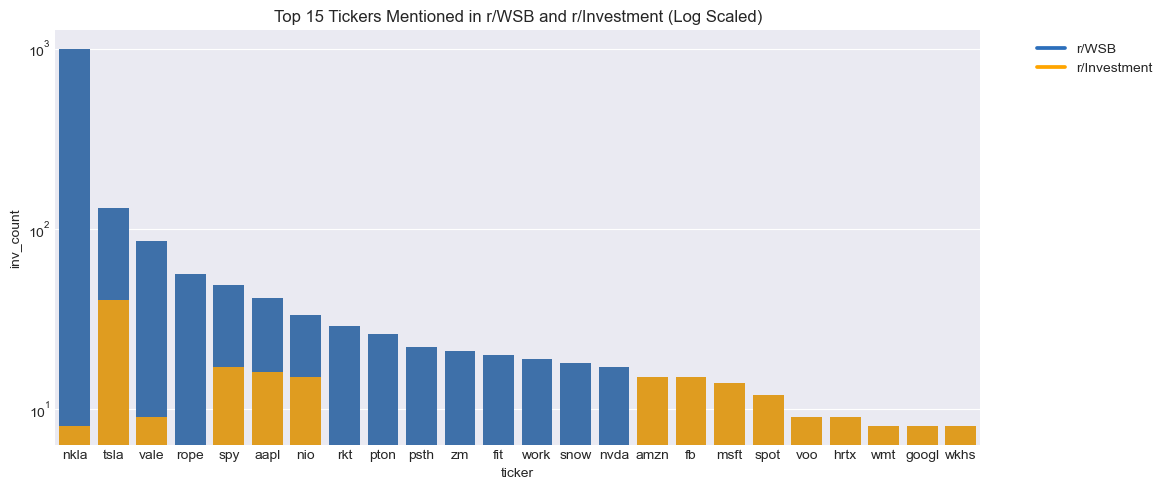

In [23]:
# seaborn stacked barplot

fig = plt.subplots(1, 1, figsize=(10,5))
sns.barplot(x=tickers_df.index, y='wsb_count', data=tickers_df, color='#2c6fbb', log=True)
sns.barplot(x=tickers_df.index, y='inv_count', data=tickers_df, color='orange', log=True)
plt.title('Top 15 Tickers Mentioned in r/WSB and r/Investment (Log Scaled)')
plt.tight_layout()
# set legend label r/WSB as blue and r/Investment as orange

leg = plt.legend(labels=['r/WSB', 'r/Investment'], loc='upper right', bbox_to_anchor=(1.2, 1.0))
leg.legendHandles[0].set_color('#2c6fbb')
leg.legendHandles[1].set_color('orange')
plt.show()

The above plot is a combination of the separate barplots displayed in the previous cells. This presentation allows us to more quickly assess the different stock tickers and the frequency of their mentions, r/WallStreetBets is in blue and r/Investing is in gold. 

We see that r/WallStreetBets posters mention specific tickers far more frequently than their r/Investing counterparts, specifically when they are excited about "piling in" to a penny stock such as NKLA, which has far more mentions in r/WallStreetBets than in r/Investing.

 We do see similar levels of mentions of the tickers SPY and AAPL. SPY is an exchange traded fund that tracks the Standard and Poors 500, and is the most traded security on the NYSE, as it is favored by both long term and short term investors alike, and AAPL is the most valuable company in the world, so it stands to reason that they might be mentioned in equal proportion amongst the two subreddits. 

### Comparison of Parts of Speech

In [15]:
# most common nouns, verbs and adjectives

# wsb
wsb_nouns = []
wsb_verbs = []
wsb_adjectives = []
for x in range(len(wsb_df)):
    doc = nlp(wsb_df['selftext_lemmatized'][x])
    for token in doc:
        if token.pos_ == 'NOUN':
            wsb_nouns.append(token.lemma_)
        if token.pos_ == 'VERB':
            wsb_verbs.append(token.lemma_)
        if token.pos_ == 'ADJ':
            wsb_adjectives.append(token.lemma_)

# inv
inv_nouns = []
inv_verbs = []
inv_adjectives = []
for x in range(len(inv_df)):
    doc = nlp(inv_df['selftext_lemmatized'][x])
    for token in doc:
        if token.pos_ == 'NOUN':
            inv_nouns.append(token.lemma_)
        if token.pos_ == 'VERB':
            inv_verbs.append(token.lemma_)
        if token.pos_ == 'ADJ':
            inv_adjectives.append(token.lemma_)


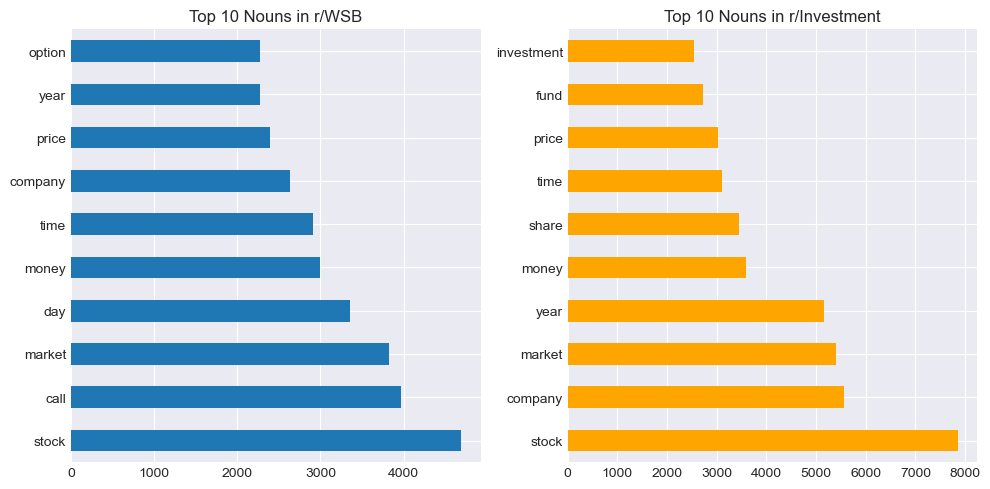

In [16]:
# pairwise comparison of top 10 nouns, verbs and adjectives

# nouns
wsb_nouns_df = pd.DataFrame(wsb_nouns, columns=['nouns'])
inv_nouns_df = pd.DataFrame(inv_nouns, columns=['nouns'])

fig, ax = plt.subplots(1, 2, figsize=(10,5))
wsb_nouns_df['nouns'].value_counts().head(10).plot(kind='barh', title='Top 10 Nouns in r/WSB', ax = ax[0])
plt.tight_layout()
inv_nouns_df['nouns'].value_counts().head(10).plot(kind='barh', color = 'orange', title='Top 10 Nouns in r/Investment')
plt.tight_layout()


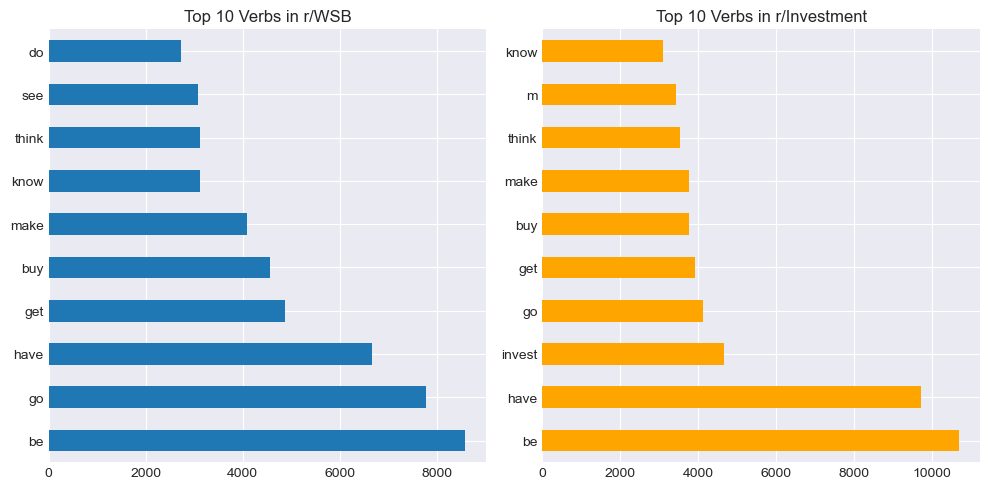

In [17]:
# vebs

wsb_verbs_df = pd.DataFrame(wsb_verbs, columns=['verbs'])
inv_verbs_df = pd.DataFrame(inv_verbs, columns=['verbs'])

fig, ax = plt.subplots(1, 2, figsize=(10,5))
wsb_verbs_df['verbs'].value_counts().head(10).plot(kind='barh', title='Top 10 Verbs in r/WSB', ax = ax[0])
plt.tight_layout()
inv_verbs_df['verbs'].value_counts().head(10).plot(kind='barh', color = 'orange', title='Top 10 Verbs in r/Investment')
plt.tight_layout()


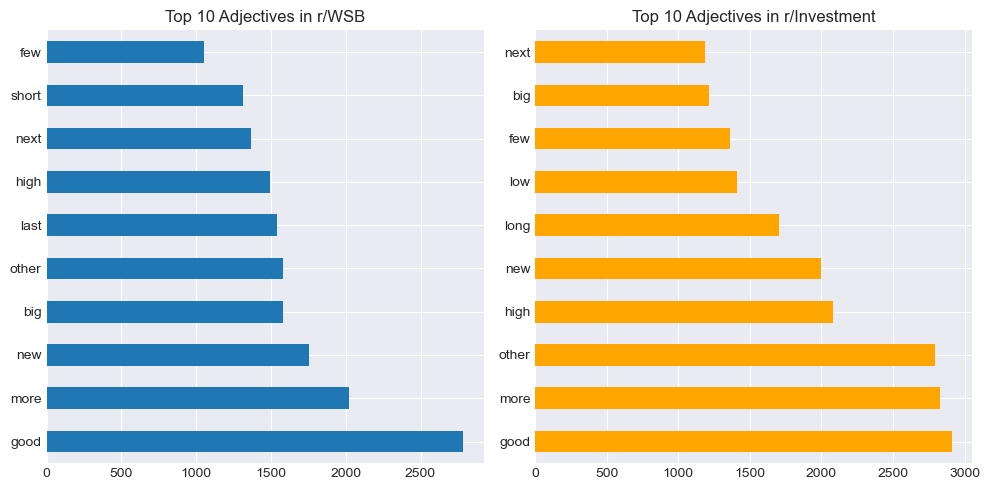

In [18]:
# adjectives

wsb_adjectives_df = pd.DataFrame(wsb_adjectives, columns=['adjectives'])
inv_adjectives_df = pd.DataFrame(inv_adjectives, columns=['adjectives'])

fig, ax = plt.subplots(1, 2, figsize=(10,5))
wsb_adjectives_df['adjectives'].value_counts().head(10).plot(kind='barh', title='Top 10 Adjectives in r/WSB', ax = ax[0])
plt.tight_layout()
inv_adjectives_df['adjectives'].value_counts().head(10).plot(kind='barh', color = 'orange', title='Top 10 Adjectives in r/Investment')
plt.tight_layout()


### Overall Similarity 

In [19]:
nlp = spacy.load('en_core_web_md')

similarity = []
for x in range(len(inv_df)):
    doc1 = nlp(wsb_df['selftext_lemmatized'][x])
    doc2 = nlp(inv_df['selftext_lemmatized'][x])
    similarity.append(doc1.similarity(doc2))

print('Overall similarity :', np.mean(similarity))

C:\Users\alexs\AppData\Local\Temp\ipykernel_40984\2479016208.py:7: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  similarity.append(doc1.similarity(doc2))


Overall similarity : 0.8141091636669466



# EDA Conclusions

An analysis of similarity between the two subreddits returns a similarity score of $.81$. Nonetheless, we believe that it may be possible to train a classification model that performs better than a class-majority baseline score, if the dissimilarities are significant enough.   

The significant difference between two subreddits lies in the use of strongly idiomatic language, such as the use of the word option or the mention of the word Tesla, or the presence of emoticon-structured sentiment such as 🍗. A spambot seeking assimilation within its chosen subreddit would need to use or *not* use this language in order to best disguise itself amongst the corpus of posts. Thus our conclusions are as follows:

1. The words Tesla and its variations as well as NKLA or Option or other short-term trading words as well as crude language and emojis is strongly r/WallStreetBets.

2. General investment language such as mentioning capital gains or even using the term investment itself is strongly *not* r/WallStreetBets. 

3. An ideal spam-bot will need to use or *not* use these crucial words in order to blend in to its chosen subreddit.

